# 0 - Imports

In [1]:
# Manejo de datos
import pandas as pd
import numpy as np
import os

# Modelo
# Uso de Grid Search para selección del modelo
from sklearn.model_selection import GridSearchCV

# MLFlow
import mlflow
import mlflow.sklearn

# Utilidades
import sys
sys.path.append("..\..")


# 0 - Carga de datos

In [2]:

X_train = pd.read_parquet("../../data/train_set_test/TfidfVectorizer/X_train.parquet")
X_val = pd.read_parquet("../../data/train_set_test/TfidfVectorizer/X_val.parquet")
Y_train = pd.read_parquet("../../data/train_set_test/TfidfVectorizer/Y_train.parquet")
Y_val = pd.read_parquet("../../data/train_set_test/TfidfVectorizer/Y_val.parquet")

# 1 - Creación del modelo

<span style="color:red">Introduce el nombre de la prueba de modelo para el regsitro MLFlow</span>

In [ ]:
name = "1_LogisticRegression"

In [3]:
# Algoritmo
from sklearn.linear_model import LogisticRegression

# Definiendo el modelo base
model = LogisticRegression(max_iter=1000, random_state=123)


## Grid Search

In [5]:
# Parámetros para Grid Search


param_grid = {
    'C': [0.001, 0.1, 10],
    'penalty': ['l1', 'l2'],
    'max_iter': [100, 1000]
}

"""
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    #'class_weight': [None, 'balanced'],
    'solver': ['sag', 'saga'],
    'max_iter': [100, 500]
}
"""

scoring = {
    'precision': 'precision',
    'recall': 'recall', 
    'f1_weighted': 'f1_weighted'
}

# Creando el objeto Grid Search
grid_search = GridSearchCV(model, 
                           param_grid, 
                           cv=5, 
                           scoring=scoring, 
                           refit = 'f1_weighted', # Parametro principal de selección de mejor modelo
                           n_jobs=-1 # Utiliza toda la potencia
                           )


In [6]:
grid_search.fit(X_train, Y_train)

c:\Users\enric\.conda\envs\npl-tweets\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
60 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\enric\.conda\envs\npl-tweets\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\enric\.conda\envs\npl-tweets\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\enric\.conda\envs\npl-tweets\lib\site-packages\sklearn\linear_model\_logistic.py", line 1169, in fit
    solver 

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=1000, random_state=123),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 500], 'penalty': ['l1', 'l2'],
                         'solver': ['sag', 'saga']},
             refit='f1_weighted',
             scoring={'f1_weighted': 'f1_weighted', 'precision': 'precision',
                      'recall': 'recall'})

In [7]:
# Imprimir los resultados
print(grid_search.best_params_)

{'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'sag'}


In [8]:
print(grid_search.best_score_)

0.7907381041087418


In [9]:
print(grid_search.best_estimator_)

LogisticRegression(C=10, random_state=123, solver='sag')


In [15]:
"""
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_score_time"], cvres["params"]):
    print("F1 score:", mean_score, "-", "Parámetros:", params)
"""

'\ncvres = grid_search.cv_results_\nfor mean_score, params in zip(cvres["mean_score_time"], cvres["params"]):\n    print("F1 score:", mean_score, "-", "Parámetros:", params)\n'

## Muestra de resultados

#### Conjunto de entrenamiento (Train)

In [16]:
# Seleccionamos el mejor modelo
best_model = grid_search.best_estimator_

In [17]:
# Predecimos con el conjunto de datos de entrenamiento
y_train_pred = best_model.predict(X_train)

Precisión: 0.9867744305657604
Recall: 0.9661870503597122
Accuracy: 0.9799103693401329
F1 score: 0.9763722282806253
AUC: 0.9782167980056485


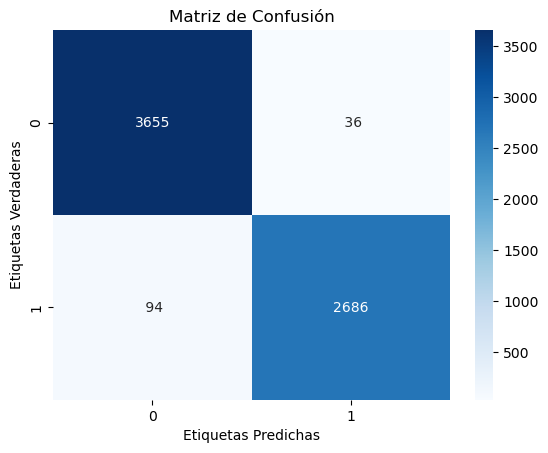

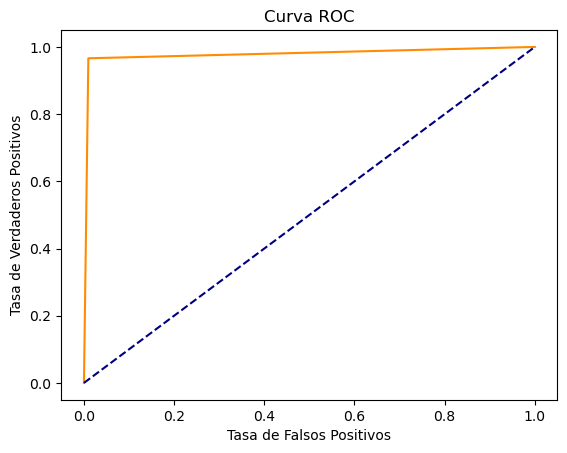

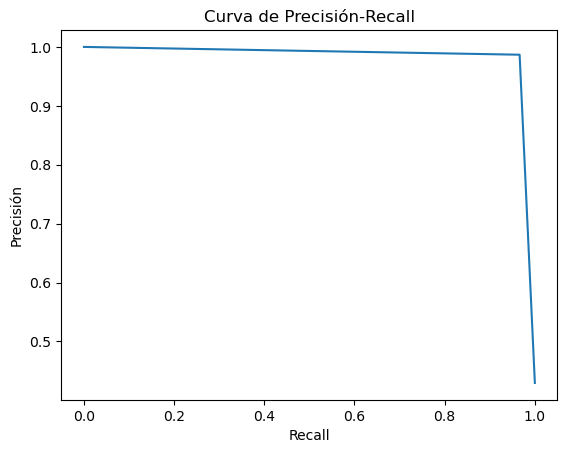

In [18]:
from package_utilities import evaluate_model
train_precision, train_recall, train_accuracy, train_f1, train_auc, train_matriz_confusion, train_curva_roc, train_curva_precision_recall =  evaluate_model(y_train_pred, Y_train)

#### Conjunto de Validación (Val)

In [19]:
# Predecimos con el conjunto de datos de entrenamiento
y_val_pred = best_model.predict(X_val)

Precisión: 0.8058252427184466
Recall: 0.6761710794297352
Accuracy: 0.7907180385288967
F1 score: 0.7353266888150609
AUC: 0.7766416073031932


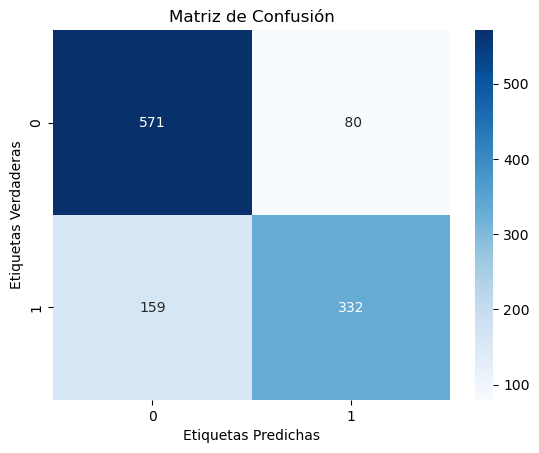

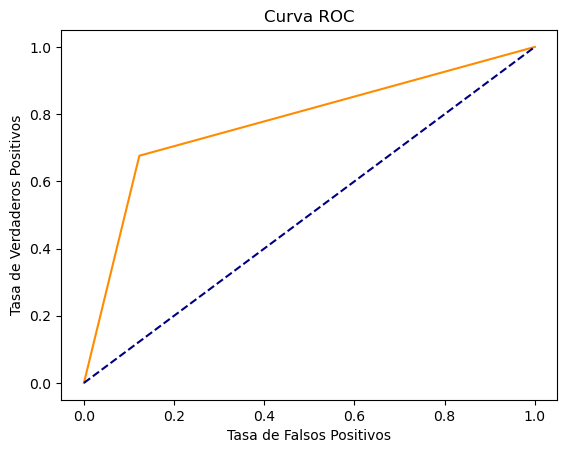

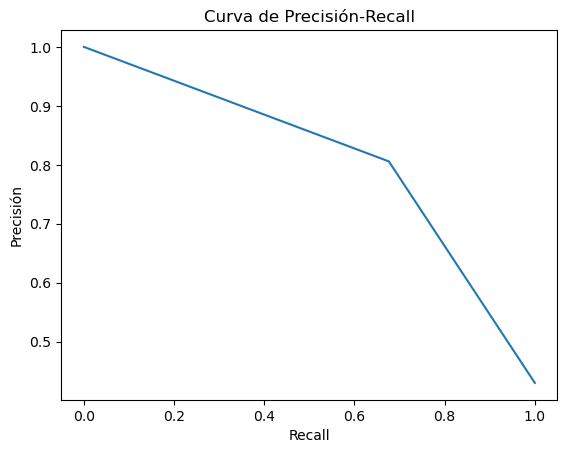

In [20]:
val_precision, val_recall, val_accuracy, val_f1, val_auc, val_matriz_confusion, val_curva_roc, val_curva_precision_recall =  evaluate_model(y_val_pred, Y_val)

### Comparación Métricas

In [22]:
col = ["Precisión", "Recall", "Accuracy", "F1 score", "AUC"]
df_metricas = pd.DataFrame(columns=col)
df_metricas.loc["Train"] = [train_precision, train_recall, train_accuracy, train_f1, train_auc]
df_metricas.loc["Validation"] = [val_precision, val_recall, val_accuracy, val_f1, val_auc]
df_metricas

,Precisión,Recall,Accuracy,F1 score,AUC
Train,0.986774,0.966187,0.979910,0.976372,0.978217
Validation,0.805825,0.676171,0.790718,0.735327,0.776642


## Guardar Modelo

### MLFlow

In [23]:
# Métodos para cargar datos mas fácilmente

def log_model(model, name):
    """Registrar el modelo en MLflow."""
    mlflow.sklearn.log_model(model, name)

def log_params(params):
    """Registrar parámetros en MLflow."""
    mlflow.log_params(params)

def log_metrics(metrics, prefix):
    """Registrar métricas en MLflow."""
    for key, value in metrics.items():
        mlflow.log_metric(f"{prefix} - {key}", value)

def log_plot(figure, name, temp_dir="temp_mlflow"):
    """Registrar gráficas en MLflow."""
    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)
    
    temp_path = os.path.join(temp_dir, name)
    figure.savefig(temp_path, format="png")
    mlflow.log_artifact(temp_path, name)
    os.remove(temp_path)


In [ ]:
def cargar_MLFlow():
    with mlflow.start_run(run_name=name):
        # Modelo
        log_model(best_model, name)

        # Parámetros
        log_params(grid_search.best_params_)

        # Métricas
        train_metrics = {
            "Precision": train_precision,
            "Recall": train_recall,
            "Accuracy": train_accuracy,
            "F1 Score": train_f1,
            "AUC": train_auc
        }
        log_metrics(train_metrics, "Train")

        val_metrics = {
            "Precision": val_precision,
            "Recall": val_recall,
            "Accuracy": val_accuracy,
            "F1 Score": val_f1,
            "AUC": val_auc
        }
        log_metrics(val_metrics, "Val")

        # Gráficas
        log_plot(train_matriz_confusion, "Train_Matriz_de_confusion.png")
        log_plot(train_curva_roc, "Train_Curva_ROC.png")
        log_plot(train_curva_precision_recall, "Train_Curva_Precision_Recall.png")

        log_plot(val_matriz_confusion, "Val_Matriz_de_confusion.png")
        log_plot(val_curva_roc, "Val_Curva_ROC.png")
        log_plot(val_curva_precision_recall, "Val_Curva_Precision_Recall.png")

Recuerda que para poder ver los modelos en MLFlow:
* Ejecutar bash --> mlflow server --host 0.0.0.0
* Puerto --> http://localhost:5000

Cambiar el Directorio de Artefactos
* mlflow server --backend-store-uri /ruta/al/directorio/deseado --host 0.0.0.0
* Ej --> mlflow server --backend-store-uri file:///C:/Users/enric/Documents/1%20-%20Inteligencia%20Artificial/Proyectos/NPL-with-Disaster-Tweets/mlflow --host 0.0.0.0
* mlflow server --host 0.0.0.0 --port 6000


In [28]:
mlflow.set_tracking_uri("../../mlflow/")
mlflow.set_experiment("NPL-Tweets")
cargar_MLFlow()

2023/10/26 16:45:28 INFO mlflow.tracking.fluent: Experiment with name 'NPL-Tweets' does not exist. Creating a new experiment.


### Guardado "físico"

In [30]:
from joblib import dump
dump(best_model, '../../models/'+name+'.joblib')

['../../models/1_LogisticRegression.joblib']